In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [7]:
mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data (you might need to adjust the path)
data = pd.read_pickle(
    "D:\\Projects\\Solar Forcasting\\Processed Data\\Pickle files\\feature_engineered_data.pkl"
)

# Extracting the important features
selected_features = [
    "Sqrt_Sum_of_Squares",
    "pca_2",
    "DNI_freq_1.429_Hz_ws_14",
    "cluster",
    "Wind Direction",
    "DNI_pse",
    "DNI_freq_1.071_Hz_ws_14",
    "DNI_freq_weighted",
    "DNI_freq_0.357_Hz_ws_14",
    "DNI_freq_0.0_Hz_ws_14",
]

# Splitting the data based on the specified years
train_data = data[data.index.year <= 2019]
test_data = data[data.index.year == 2020]

# Extracting the features and target variable for both training and testing data
X_train = train_data[selected_features]
y_train = train_data["DNI"]
X_test = test_data[selected_features]
y_test = test_data["DNI"]

# Normalizing the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_normalized = scaler_X.fit_transform(X_train)
X_test_normalized = scaler_X.transform(
    X_test
)  # Use transform to ensure the scale is the same as training data

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_normalized = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_normalized = scaler_y.transform(y_test.values.reshape(-1, 1))


# Function to transform data into the format suitable for LSTM
def create_lstm_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i : (i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


# Transforming data for LSTM (using a time step of 1)
TIME_STEPS = 1
X_train_lstm, y_train_lstm = create_lstm_dataset(
    X_train_normalized, y_train_normalized, TIME_STEPS
)
X_test_lstm, y_test_lstm = create_lstm_dataset(
    X_test_normalized, y_test_normalized, TIME_STEPS
)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` in

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping


# Define the extended LSTM model
def create_extended_model(
    num_units=50, lr=0.001, activation="relu", dropout_rate=0.0, optimizer_name="Adam"
):
    model = Sequential()
    model.add(
        LSTM(
            units=num_units,
            return_sequences=True,
            input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
        )
    )
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=num_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=30, activation=activation))
    model.add(Dense(units=1))

    if optimizer_name == "Adam":
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == "SGD":
        optimizer = SGD(learning_rate=lr)
    else:
        optimizer = RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model


# Optuna objective function
def extended_objective(trial):
    num_units = trial.suggest_int("num_units", 30, 200)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256])
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
    optimizer_name = trial.suggest_categorical(
        "optimizer_name", ["Adam", "SGD", "RMSprop"]
    )

    model = create_extended_model(
        num_units=num_units,
        lr=lr,
        activation=activation,
        dropout_rate=dropout_rate,
        optimizer_name=optimizer_name,
    )
    early_stop = EarlyStopping(monitor="val_loss", patience=5)
    history = model.fit(
        X_train_lstm,
        y_train_lstm,
        epochs=50,
        batch_size=batch_size,
        validation_data=(X_test_lstm, y_test_lstm),
        callbacks=[early_stop],
        verbose=0,
        shuffle=False,
    )
    val_loss = history.history["val_loss"][-1]
    return val_loss


# Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(
    extended_objective, n_trials=10
)  # Adjust n_trials based on your computational capacity

# Get best parameters
best_params = study.best_params

# Retrain the model with best parameters
optimized_model = create_extended_model(
    num_units=best_params["num_units"],
    lr=best_params["lr"],
    activation=best_params["activation"],
    dropout_rate=best_params["dropout_rate"],
    optimizer_name=best_params["optimizer_name"],
)
optimized_history = optimized_model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,
    batch_size=best_params["batch_size"],
    validation_data=(X_test_lstm, y_test_lstm),
    shuffle=False,
)

# Evaluate the optimized model
optimized_loss = optimized_model.evaluate(X_test_lstm, y_test_lstm)
print(f"Optimized Model Loss: {optimized_loss}")

[I 2023-10-31 14:47:21,304] A new study created in memory with name: no-name-60be635d-9c79-41bb-8013-c08448d5583f
C:\Users\user\AppData\Local\Temp\ipykernel_16144\3299012248.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
C:\Users\user\AppData\Local\Temp\ipykernel_16144\3299012248.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
[I 2023-10-31 15:36:04,545] Trial 0 finished with value: 0.00044903039815835655 and parameters: {'num_units': 179, 'lr': 0.00027289397847187483, 'batch_size': 32, 'activation': 'sigmoid', 'dropout_rate': 0.4768853302210046, 'optimizer_name': 'RM

KeyboardInterrupt: 

Epoch 1/50
6572/6572 [==============================] - 66s 9ms/step - loss: 0.0094 - val_loss: 0.0047
Epoch 2/50
6572/6572 [==============================] - 59s 9ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 3/50
6572/6572 [==============================] - 61s 9ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 4/50
6572/6572 [==============================] - 58s 9ms/step - loss: 9.4083e-04 - val_loss: 0.0054
Epoch 5/50
6572/6572 [==============================] - 58s 9ms/step - loss: 8.8373e-04 - val_loss: 0.0049
Epoch 6/50
6572/6572 [==============================] - 60s 9ms/step - loss: 8.4497e-04 - val_loss: 0.0040
Epoch 7/50
6572/6572 [==============================] - 61s 9ms/step - loss: 8.1065e-04 - val_loss: 0.0041
Epoch 8/50
6572/6572 [==============================] - 71s 11ms/step - loss: 7.8246e-04 - val_loss: 0.0032
Epoch 9/50
6572/6572 [==============================] - 60s 9ms/step - loss: 7.5412e-04 - val_loss: 0.0031
Epoch 10/50
6572/6572 [=========================

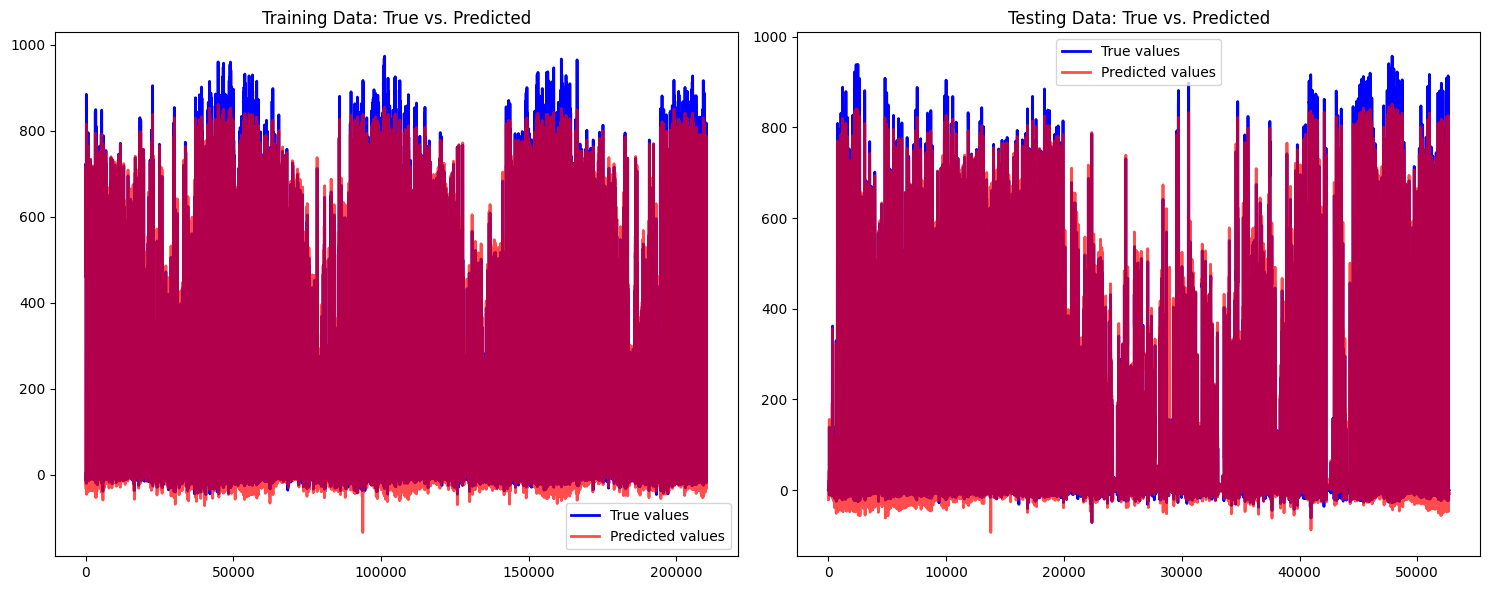

In [13]:
best_params = {
    "num_units": 179,
    "lr": 0.00027289397847187483,
    "batch_size": 32,
    "activation": "sigmoid",
    "dropout_rate": 0.4768853302210046,
    "optimizer_name": "RMSprop",
}

# 1. Train the LSTM model using the best parameters
optimized_model = create_extended_model(
    num_units=best_params["num_units"],
    lr=best_params["lr"],
    activation=best_params["activation"],
    dropout_rate=best_params["dropout_rate"],
    optimizer_name=best_params["optimizer_name"],
)
history = optimized_model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,  # you can adjust this
    batch_size=best_params["batch_size"],
    validation_data=(X_test_lstm, y_test_lstm),
    shuffle=False,
)

# 2. Predict using the trained model
y_train_predicted = optimized_model.predict(X_train_lstm)
y_test_predicted = optimized_model.predict(X_test_lstm)

# Inverse transform to get the original scale of values
y_train_predicted_original = scaler_y.inverse_transform(y_train_predicted)
y_test_predicted_original = scaler_y.inverse_transform(y_test_predicted)
y_train_original = scaler_y.inverse_transform(y_train_lstm)
y_test_original = scaler_y.inverse_transform(y_test_lstm)

# 3. Visualize the model's performance

# Training data
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(y_train_original, label="True values", color="blue")
plt.plot(y_train_predicted_original, label="Predicted values", color="red", alpha=0.7)
plt.title("Training Data: True vs. Predicted")
plt.legend()

# Testing data
plt.subplot(1, 2, 2)
plt.plot(y_test_original, label="True values", color="blue")
plt.plot(y_test_predicted_original, label="Predicted values", color="red", alpha=0.7)
plt.title("Testing Data: True vs. Predicted")
plt.legend()

plt.tight_layout()
plt.show()

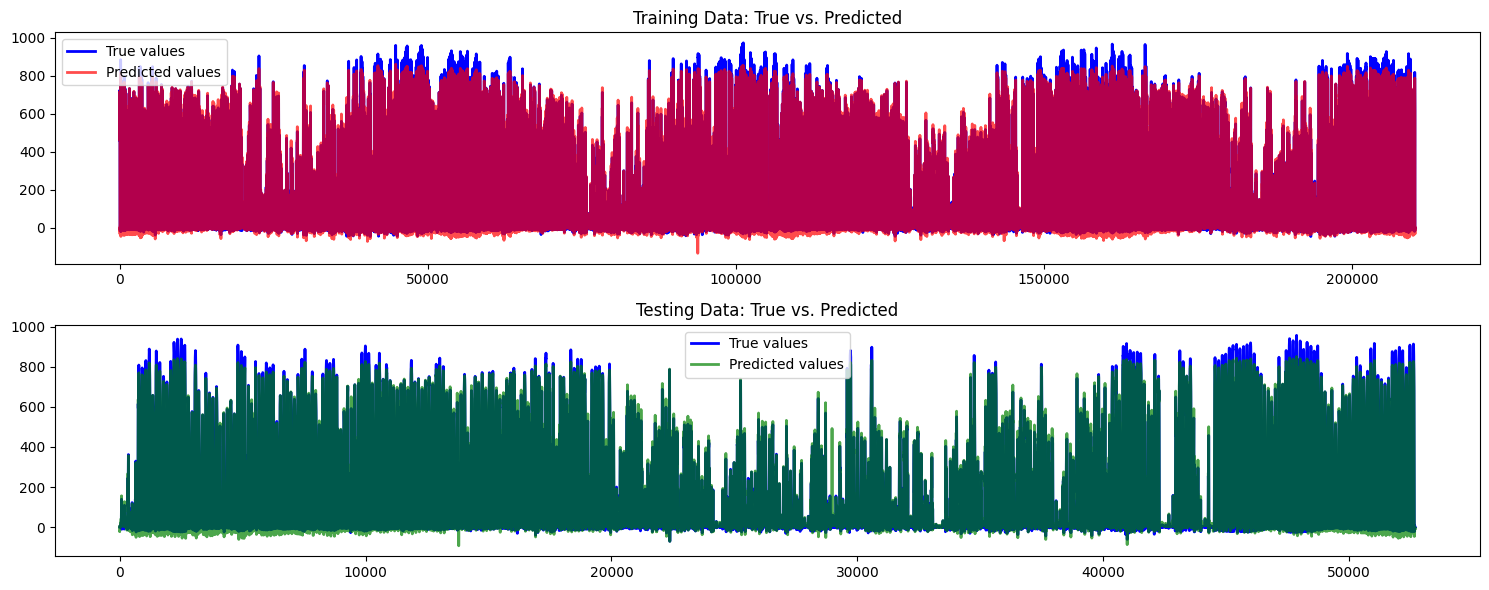

In [39]:
# 3. Visualize the model's performance

# Training data
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(y_train_original, label="True values", color="blue")
plt.plot(y_train_predicted_original, label="Predicted values", color="red", alpha=0.7)
plt.title("Training Data: True vs. Predicted")
plt.legend()

# Testing data
plt.subplot(2, 1, 2)
plt.plot(y_test_original, label="True values", color="blue")
plt.plot(y_test_predicted_original, label="Predicted values", color="green", alpha=0.7)
plt.title("Testing Data: True vs. Predicted")
plt.legend()

plt.tight_layout()
plt.show()

1647/1647 [==============================] - 4s 3ms/step


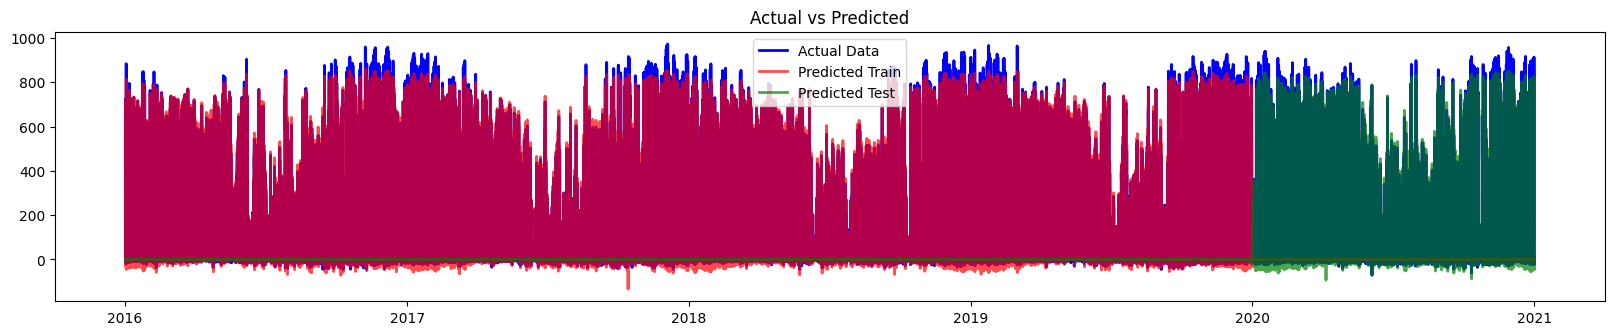

In [40]:
import matplotlib.pyplot as plt

# Predictions
train_predictions = optimized_model.predict(X_train_lstm)
test_predictions = optimized_model.predict(X_test_lstm)

# Transform predictions back to original scale
train_predictions_original = scaler_y.inverse_transform(train_predictions)
test_predictions_original = scaler_y.inverse_transform(test_predictions)

# Create an array for the predictions to match the original data length
predicted_train = np.zeros(shape=(len(data), 1))
predicted_test = np.zeros(shape=(len(data), 1))

# Assign predictions to their respective positions
predicted_train[
    TIME_STEPS : len(train_predictions) + TIME_STEPS, :
] = train_predictions_original
predicted_test[
    len(train_predictions) + (2 * TIME_STEPS) :, :
] = test_predictions_original

# Plotting
plt.figure(figsize=(20, 3.5))
plt.plot(data.index, data["DNI"], label="Actual Data", color="blue")
plt.plot(data.index, predicted_train, label="Predicted Train", color="red", alpha=0.7)
plt.plot(data.index, predicted_test, label="Predicted Test", color="green", alpha=0.7)
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

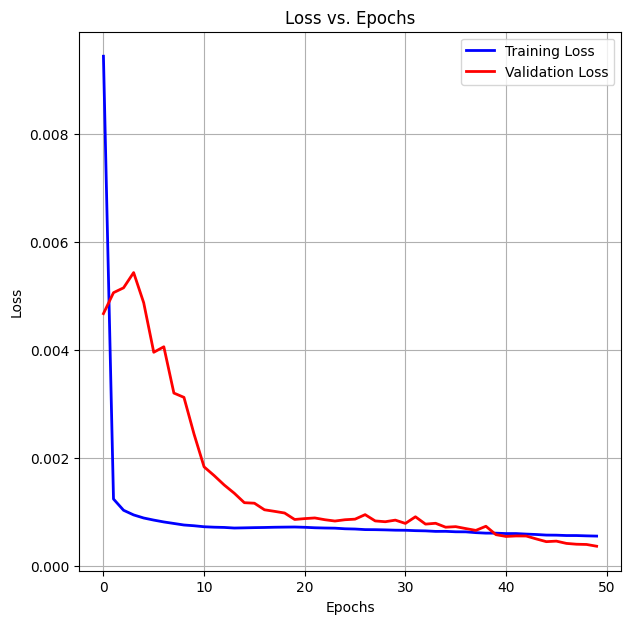

In [20]:
# Extracting loss and validation loss values from the training history
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Generating the plot
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="red")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate error metrics for training data
mse_train = mean_squared_error(y_train_original, y_train_predicted_original)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_predicted_original)
r2_train = r2_score(y_train_original, y_train_predicted_original)

# Calculate error metrics for testing data
mse_test = mean_squared_error(y_test_original, y_test_predicted_original)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_original, y_test_predicted_original)
r2_test = r2_score(y_test_original, y_test_predicted_original)

# Store the results in a DataFrame
results_df = pd.DataFrame(
    {
        "Dataset": ["Training", "Testing"],
        "MSE": [mse_train, mse_test],
        "RMSE": [rmse_train, rmse_test],
        "MAE": [mae_train, mae_test],
        "R^2": [r2_train, r2_test],
    }
)

print(results_df)

    Dataset         MSE       RMSE        MAE       R^2
0  Training  318.142379  17.836546  13.016698  0.995319
1   Testing  375.104563  19.367616  14.269703  0.994863


In [23]:
results_df

,Dataset,MSE,RMSE,MAE,R^2
0,Training,318.142379,17.836546,13.016698,0.995319
1,Testing,375.104563,19.367616,14.269703,0.994863


In [24]:
reshaped_df = results_df.melt(
    id_vars=["Dataset"],
    value_vars=["MSE", "RMSE", "MAE", "R^2"],
    var_name="Metric",
    value_name="Value",
)

# Pivot the reshaped DataFrame to get the desired format
final_df = reshaped_df.pivot(
    index="Metric", columns="Dataset", values="Value"
).reset_index()

In [25]:
final_df

Dataset,Metric,Testing,Training
0,MAE,14.269703,13.016698
1,MSE,375.104563,318.142379
2,RMSE,19.367616,17.836546
3,R^2,0.994863,0.995319


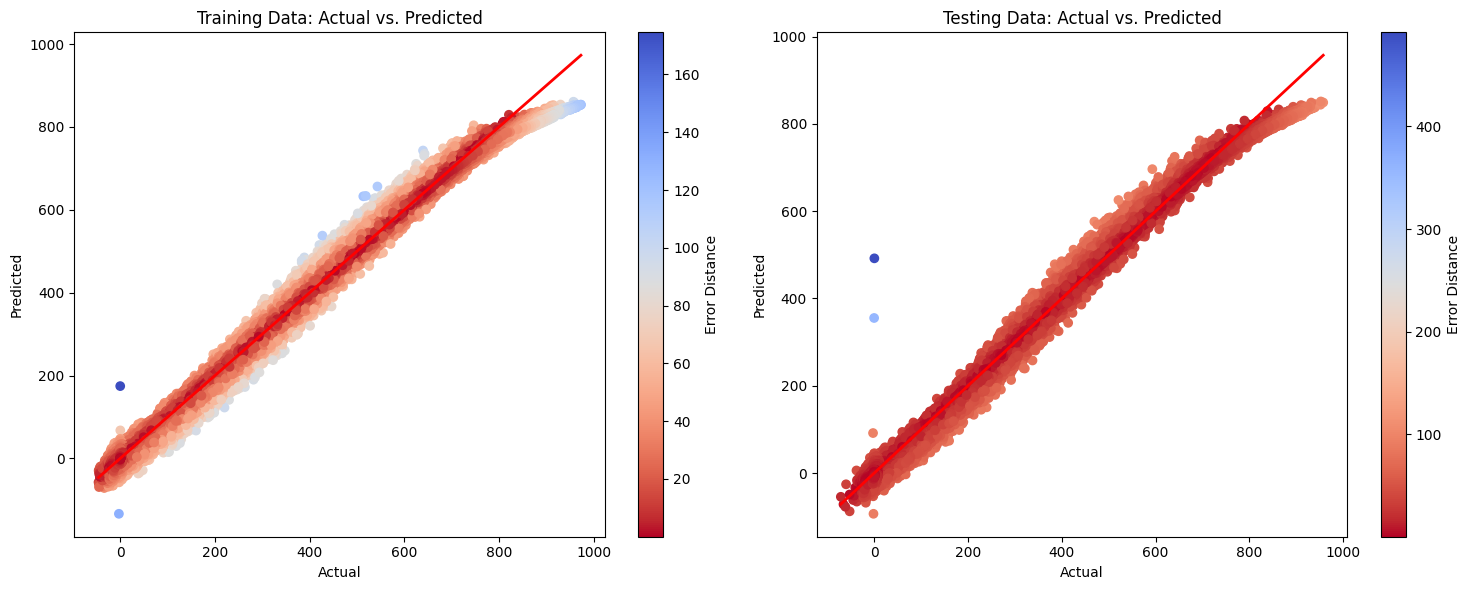

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the error distances for training and testing data
error_train = np.abs(y_train_original.flatten() - y_train_predicted_original.flatten())
error_test = np.abs(y_test_original.flatten() - y_test_predicted_original.flatten())

# Plotting
plt.figure(figsize=(15, 6))

# Training Data
plt.subplot(1, 2, 1)
scatter = plt.scatter(
    y_train_original, y_train_predicted_original, c=error_train, cmap="coolwarm_r"
)
plt.plot(
    [min(y_train_original), max(y_train_original)],
    [min(y_train_original), max(y_train_original)],
    "r",
)
plt.colorbar(scatter, label="Error Distance")
plt.title("Training Data: Actual vs. Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# Testing Data
plt.subplot(1, 2, 2)
scatter = plt.scatter(
    y_test_original, y_test_predicted_original, c=error_test, cmap="coolwarm_r"
)
plt.plot(
    [min(y_test_original), max(y_test_original)],
    [min(y_test_original), max(y_test_original)],
    "r",
)
plt.colorbar(scatter, label="Error Distance")
plt.title("Testing Data: Actual vs. Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()

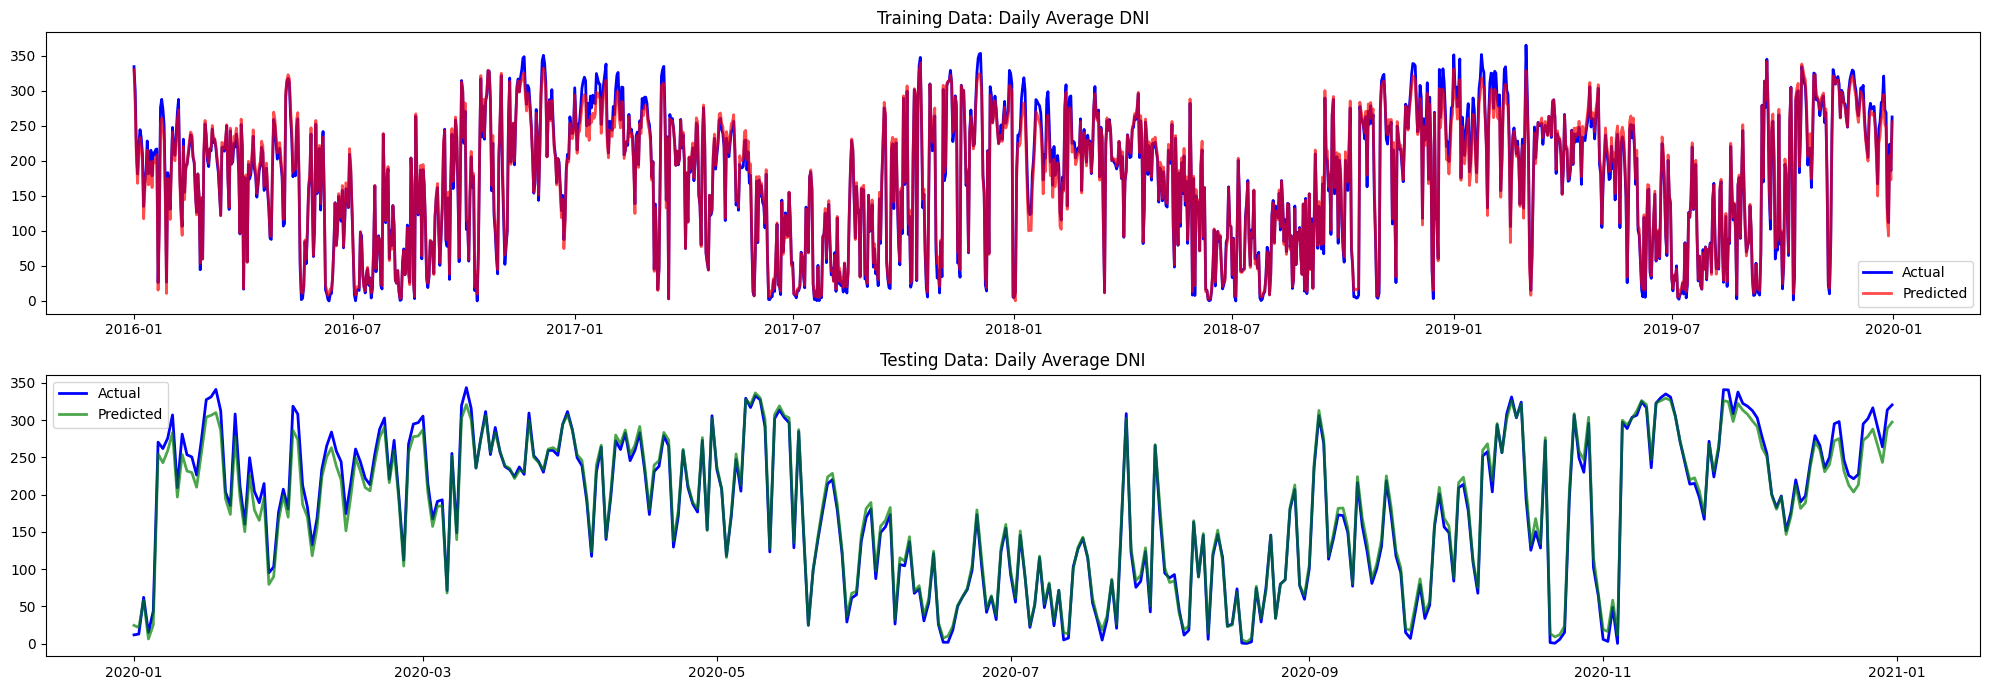

In [32]:
# 1. Extract the timestamps corresponding to the LSTM-transformed data
train_time = train_data.index[TIME_STEPS:]
test_time = test_data.index[TIME_STEPS:]

# 2. Aggregate the actual and predicted values to get daily averages
train_actual_daily = (
    pd.Series(y_train_original.flatten(), index=train_time).resample("D").mean()
)
train_predicted_daily = (
    pd.Series(y_train_predicted_original.flatten(), index=train_time)
    .resample("D")
    .mean()
)

test_actual_daily = (
    pd.Series(y_test_original.flatten(), index=test_time).resample("D").mean()
)
test_predicted_daily = (
    pd.Series(y_test_predicted_original.flatten(), index=test_time).resample("D").mean()
)

# 3. Plot the daily average values against time

plt.figure(figsize=(20, 7))

# Training Data
plt.subplot(2, 1, 1)
plt.plot(train_actual_daily, label="Actual", color="blue")
plt.plot(train_predicted_daily, label="Predicted", color="red", alpha=0.7)
plt.title("Training Data: Daily Average DNI")
plt.legend()

# Testing Data
plt.subplot(2, 1, 2)
plt.plot(test_actual_daily, label="Actual", color="blue")
plt.plot(test_predicted_daily, label="Predicted", color="green", alpha=0.7)
plt.title("Testing Data: Daily Average DNI")
plt.legend()

plt.tight_layout()
plt.show()

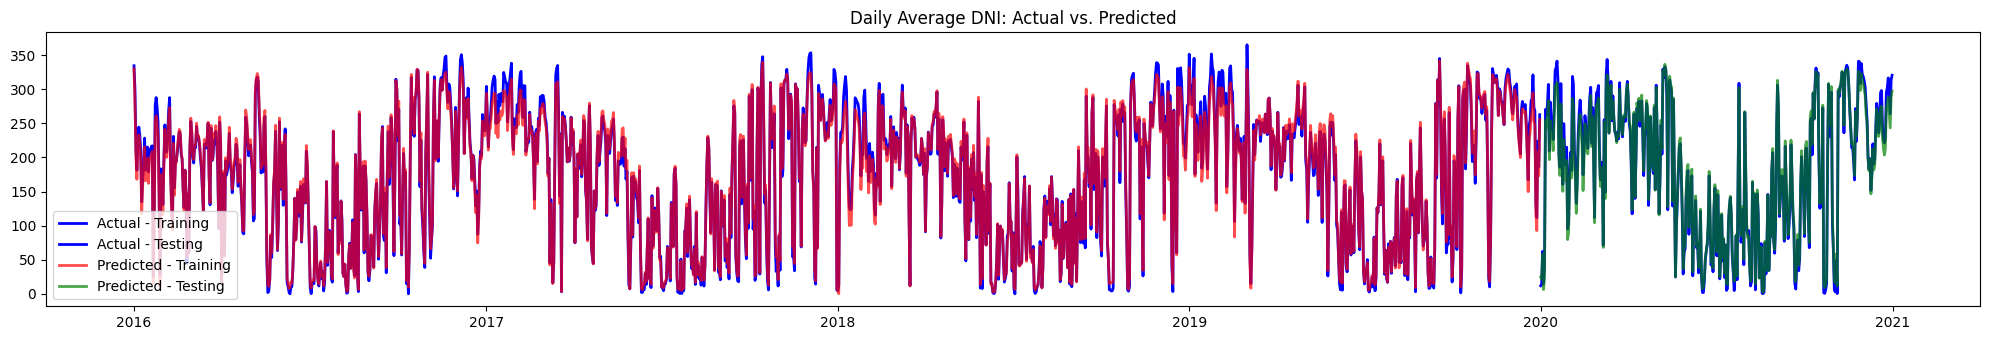

In [37]:
# 1. Extract the timestamps corresponding to the LSTM-transformed data
train_time = train_data.index[TIME_STEPS:]
test_time = test_data.index[TIME_STEPS:]

# 2. Aggregate the actual and predicted values to get daily averages
train_actual_daily = (
    pd.Series(y_train_original.flatten(), index=train_time).resample("D").mean()
)
train_predicted_daily = (
    pd.Series(y_train_predicted_original.flatten(), index=train_time)
    .resample("D")
    .mean()
)

test_actual_daily = (
    pd.Series(y_test_original.flatten(), index=test_time).resample("D").mean()
)
test_predicted_daily = (
    pd.Series(y_test_predicted_original.flatten(), index=test_time).resample("D").mean()
)

# 3. Plot the daily average values against time

plt.figure(figsize=(20, 3.5))

# Plotting actual values for both training and testing data
plt.plot(
    train_actual_daily.index,
    train_actual_daily,
    label="Actual - Training",
    color="blue",
)
plt.plot(
    test_actual_daily.index, test_actual_daily, label="Actual - Testing", color="blue"
)

# Plotting predicted values for training and testing data
plt.plot(
    train_predicted_daily.index,
    train_predicted_daily,
    label="Predicted - Training",
    color="red",
    alpha=0.7,
)
plt.plot(
    test_predicted_daily.index,
    test_predicted_daily,
    label="Predicted - Testing",
    color="green",
    alpha=0.7,
)

plt.title("Daily Average DNI: Actual vs. Predicted")
plt.legend()
plt.tight_layout()
plt.show()